In [1]:
!nvidia-smi

Thu Apr  7 05:46:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Generator

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = (0.1, 0.25),
                                   rotation_range = 20,
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                   validation_split = 0.15)

# valid_datagen =  ImageDataGenerator(rescale = 1/255.0,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    brightness_range = (0.1, 0.25),
#                                    rotation_range = 20,
#                                    vertical_flip = True,
#                                    horizontal_flip = True,)
 
test_datagen =  ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = (0.1, 0.25),
                                   rotation_range = 20,
                                   vertical_flip = True,
                                   horizontal_flip = True,)
    
    
training_set = train_datagen.flow_from_directory('../input/cats-vs-dogs-training8000test2000/dataset/training_set/',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 subset = 'training')

valid_set = train_datagen.flow_from_directory('../input/cats-vs-dogs-training8000test2000/dataset/training_set/',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            subset = 'validation'
                                            )

test_set = test_datagen.flow_from_directory('../input/cats-vs-dogs-training8000test2000/dataset/test_set/',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',)

Found 6800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# SQNET

In [19]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
from keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense
from keras.models import Model


def SqueezeNet(input_shape, classes):


  def Fire(inputs, fs, fe):
    
    s1 = Conv2D(filters=fs, kernel_size=1, padding='same', use_bias=False, activation='relu')(inputs)
    s1 = BatchNormalization()(s1)
    e1 = Conv2D(filters=fe, kernel_size=1, padding='same', use_bias=False, activation='relu')(s1)
    e1 = BatchNormalization()(e1)
    e3 = Conv2D(filters=fe, kernel_size=3, padding='same', use_bias=False, activation='relu')(s1)
    e3 = BatchNormalization()(e3)

    output = Concatenate()([e1, e3])
  
    return output


  inputs = Input(input_shape)
  x1 = Conv2D(filters=96, kernel_size=7, strides=2, padding='same', use_bias=False, activation='relu')(inputs)
  x1= s1 = BatchNormalization()(x1)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(x1)

  f2 = Fire(x1, 16, 64)
  f3 = Fire(f2, 16, 64)
  f4 = Fire(f3, 32, 128)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f4)

  f5 = Fire(x1, 32, 128)
  f6 = Fire(f5, 48, 192)
  f7 = Fire(f6, 48, 192)
  f8 = Fire(f7, 64, 256)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f8)

  f8 = Fire(x1, 64, 256)
  x1 = Conv2D(filters=classes, kernel_size=1)(f8)
  x1 = GlobalAveragePooling2D()(x1)

  if classes == 1:
    x1 = Activation('sigmoid')(x1)
  else:
    x1 = Activation('softmax')(x1)

  model = Model(inputs=inputs, outputs=x1)
  # model.summary()

  return model



In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import tensorflow as tf

""" callbacks """
checkpoint_filepath = './SQNet_{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 3,
    save_best_only=False)

csv_path = "./SQNet.csv"
callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=8)
]

In [5]:
model = SqueezeNet(input_shape = (224, 224, 3), classes=2)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy']
)

r1 = model.fit(
  training_set,
  validation_data=valid_set,
  batch_size=64,
  epochs=100,
  steps_per_epoch=len(training_set),
  workers=-1,
  use_multiprocessing=True,
  validation_steps=len(valid_set),
  callbacks=callbacks
)

model.save('./SqueezeNet.h5')

model.evaluate_generator(test_set, steps=64, workers=-1, use_multiprocessing=True)

Epoch 1/100
107/107 [==============================] - 135s 1s/step - loss: 0.8113 - accuracy: 0.5324 - val_loss: 1.4445 - val_accuracy: 0.5083
Epoch 2/100
107/107 [==============================] - 132s 1s/step - loss: 0.7225 - accuracy: 0.5356 - val_loss: 0.6971 - val_accuracy: 0.5558
Epoch 3/100
107/107 [==============================] - 131s 1s/step - loss: 0.6931 - accuracy: 0.5635 - val_loss: 0.8651 - val_accuracy: 0.5075

Epoch 00003: saving model to ./SQNet_3.h5
Epoch 4/100
107/107 [==============================] - 127s 1s/step - loss: 0.6867 - accuracy: 0.5749 - val_loss: 0.7023 - val_accuracy: 0.5833
Epoch 5/100
107/107 [==============================] - 128s 1s/step - loss: 0.6816 - accuracy: 0.5919 - val_loss: 0.8776 - val_accuracy: 0.5292
Epoch 6/100
107/107 [==============================] - 128s 1s/step - loss: 0.6662 - accuracy: 0.6093 - val_loss: 0.6855 - val_accuracy: 0.5250

Epoch 00006: saving model to ./SQNet_6.h5
Epoch 7/100
107/107 [=============================

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.41946253180503845, 0.8694999814033508]

In [5]:
model = SqueezeNet(input_shape = (224, 224, 3), classes=2)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy']
)

r1 = model.fit(
  training_set,
  validation_data=valid_set,
  batch_size=64,
  epochs=100,
  steps_per_epoch=len(training_set),
  workers=-1,
  use_multiprocessing=True,
  validation_steps=len(valid_set),
  callbacks=callbacks
)

model.save('./SqueezeNet.h5')

model.evaluate_generator(test_set, steps=64, workers=-1, use_multiprocessing=True)

Epoch 1/100
107/107 [==============================] - 135s 1s/step - loss: 0.8113 - accuracy: 0.5324 - val_loss: 1.4445 - val_accuracy: 0.5083
Epoch 2/100
107/107 [==============================] - 132s 1s/step - loss: 0.7225 - accuracy: 0.5356 - val_loss: 0.6971 - val_accuracy: 0.5558
Epoch 3/100
107/107 [==============================] - 131s 1s/step - loss: 0.6931 - accuracy: 0.5635 - val_loss: 0.8651 - val_accuracy: 0.5075

Epoch 00003: saving model to ./SQNet_3.h5
Epoch 4/100
107/107 [==============================] - 127s 1s/step - loss: 0.6867 - accuracy: 0.5749 - val_loss: 0.7023 - val_accuracy: 0.5833
Epoch 5/100
107/107 [==============================] - 128s 1s/step - loss: 0.6816 - accuracy: 0.5919 - val_loss: 0.8776 - val_accuracy: 0.5292
Epoch 6/100
107/107 [==============================] - 128s 1s/step - loss: 0.6662 - accuracy: 0.6093 - val_loss: 0.6855 - val_accuracy: 0.5250

Epoch 00006: saving model to ./SQNet_6.h5
Epoch 7/100
107/107 [=============================

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.41946253180503845, 0.8694999814033508]

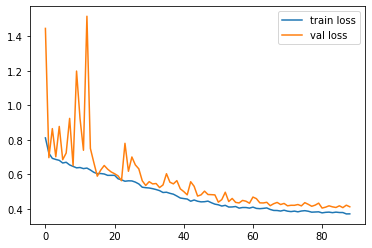

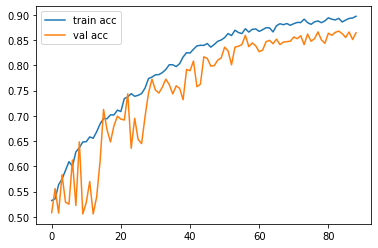

In [11]:
import matplotlib.pyplot as plt

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [21]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 112, 112, 96) 14112       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 112, 112, 96) 384         conv2d_78[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 56, 56, 96)   0           batch_normalization_75[0][0]     
____________________________________________________________________________________________

# SQNETSE

In [13]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
from keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense, Multiply
from keras.models import Model


def SqueezeNetSE(input_shape, classes):


  def SqueezeAndExcitation(inputs, ratio=8):
    
    b, h, w, c = inputs.shape
    
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)
    
    x = Multiply()([inputs, x])
    
    return x


  def Fire(inputs, fs, fe):
    
    s1 = Conv2D(filters=fs, kernel_size=1, padding='same', use_bias=False, activation='relu')(inputs)
    s1 = BatchNormalization()(s1)
    e1 = Conv2D(filters=fe, kernel_size=1, padding='same', use_bias=False, activation='relu')(s1)
    e1 = BatchNormalization()(e1)
    e3 = Conv2D(filters=fe, kernel_size=3, padding='same', use_bias=False, activation='relu')(s1)
    e3 = BatchNormalization()(e3)

    output = Concatenate()([e1, e3])
  
    return output


  inputs = Input(input_shape)
  x1 = Conv2D(filters=96, kernel_size=7, strides=2, padding='same', use_bias=False, activation='relu')(inputs)
  x1= s1 = BatchNormalization()(x1)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(x1)

  f2 = Fire(x1, 16, 64)
  f3 = Fire(f2, 16, 64)
  f4 = Fire(f3, 32, 128)
  f4 = SqueezeAndExcitation(f4, ratio=16)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f4)

  f5 = Fire(x1, 32, 128)
  f6 = Fire(f5, 48, 192)
  f7 = Fire(f6, 48, 192)
  f8 = Fire(f7, 64, 256)
  f8 = SqueezeAndExcitation(f8, ratio=16)

  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f8)

  f8 = Fire(x1, 64, 256)
  x1 = Conv2D(filters=classes, kernel_size=1)(f8)
  x1 = GlobalAveragePooling2D()(x1)

  if classes == 1:
    x1 = Activation('sigmoid')(x1)
  else:
      x1 = Activation('softmax')(x1)

  model = Model(inputs=inputs, outputs=x1)
  # model.summary()

  return model


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import tensorflow as tf

""" callbacks """
checkpoint_filepath = './SQNetSE_{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 3,
    save_best_only=False)

csv_path = "./SQNetSE.csv"
callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=8)
]

In [15]:
model = SqueezeNetSE(input_shape = (224, 224, 3), classes=2)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy']
)

r1 = model.fit(
  training_set,
  validation_data=valid_set,
  batch_size=64,
  epochs=100,
  steps_per_epoch=len(training_set),
  workers=-1,
  use_multiprocessing=True,
  validation_steps=len(valid_set),
  callbacks=callbacks
)

model.save('./SqueezeNetSE.h5')

model.evaluate(test_set, steps=64, workers=-1, use_multiprocessing=True)

Epoch 1/100
107/107 [==============================] - 133s 1s/step - loss: 0.7979 - accuracy: 0.5293 - val_loss: 1.3527 - val_accuracy: 0.5250
Epoch 2/100
107/107 [==============================] - 128s 1s/step - loss: 0.6900 - accuracy: 0.5706 - val_loss: 0.7024 - val_accuracy: 0.5167
Epoch 3/100
107/107 [==============================] - 130s 1s/step - loss: 0.6822 - accuracy: 0.5801 - val_loss: 0.6982 - val_accuracy: 0.5767

Epoch 00003: saving model to ./SQNetSE_3.h5
Epoch 4/100
107/107 [==============================] - 130s 1s/step - loss: 0.6663 - accuracy: 0.6090 - val_loss: 0.7199 - val_accuracy: 0.5675
Epoch 5/100
107/107 [==============================] - 131s 1s/step - loss: 0.6627 - accuracy: 0.6179 - val_loss: 2.3796 - val_accuracy: 0.4917
Epoch 6/100
107/107 [==============================] - 130s 1s/step - loss: 0.6562 - accuracy: 0.6297 - val_loss: 0.7249 - val_accuracy: 0.5333

Epoch 00006: saving model to ./SQNetSE_6.h5
Epoch 7/100
107/107 [=========================

[0.4132039546966553, 0.862500011920929]

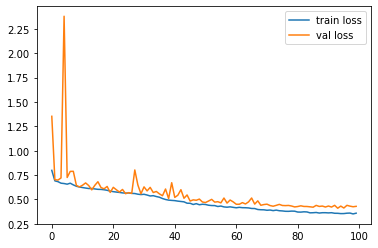

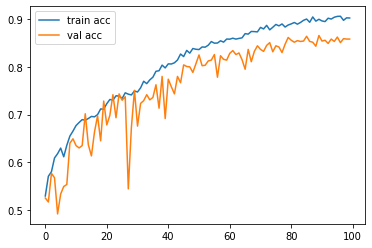

In [ ]:
import matplotlib.pyplot as plt

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [17]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 112, 112, 96) 14112       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 112, 112, 96) 384         conv2d_52[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 56, 56, 96)   0           batch_normalization_50[0][0]     
____________________________________________________________________________________________